In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Dropout, Input, Dense, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model

In [3]:
path = Path("./UTKFace/")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

np.random.seed(10)
np.random.shuffle(filenames)

age_labels, gender_labels, image_path = [], [], []
for filename in filenames:
    image_path.append(filename)
    temp = filename.split('_')
    age_labels.append(int(temp[0]))
    gender_labels.append(int(temp[1]))

df = pd.DataFrame({'image': image_path, 'age': age_labels, 'gender': gender_labels})

df['age'] = df['age'] / 100.0

In [4]:
df = df.dropna()

train, test = train_test_split(df, test_size=0.15, random_state=42)

train_data, val_data = train_test_split(train, test_size=0.2, random_state=42)

In [5]:
def preprocess_images(image_files):
    images = []
    for file in image_files:
        img = load_img("UTKFace/"+file, color_mode="grayscale")
        img = img.resize((128, 128), Image.LANCZOS)
        img = np.array(img) / 255.0
        images.append(img)
    return np.array(images).reshape(len(images), 128, 128, 1)

In [6]:
x_train = preprocess_images(train_data.image)
x_val = preprocess_images(val_data.image)

y_train = np.array(train_data.age)
y_val = np.array(val_data.age)

In [ ]:
input_size = (128, 128, 1)
inputs = Input((input_size))

X = Conv2D(64, (3, 3), activation='relu', kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis=3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.4)(X)

output_age = Dense(1, activation='linear', name='age_output')(X)  # Sortie continue

model_age = Model(inputs=inputs, outputs=output_age)
model_age.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

In [7]:
model_age.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 64)      640       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 42, 42, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0     

In [8]:
#Train_model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model_age.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_val, y_val), callbacks=[early_stopping])

Epoch 1/10
504/504 [==============================] - 352s 699ms/step - loss: 0.0205 - mae: 0.1087 - val_loss: 0.0196 - val_mae: 0.1073
Epoch 2/10
504/504 [==============================] - 356s 707ms/step - loss: 0.0190 - mae: 0.1044 - val_loss: 0.0176 - val_mae: 0.0985
Epoch 3/10
504/504 [==============================] - 370s 734ms/step - loss: 0.0176 - mae: 0.1001 - val_loss: 0.0148 - val_mae: 0.0906
Epoch 4/10
504/504 [==============================] - 368s 731ms/step - loss: 0.0162 - mae: 0.0956 - val_loss: 0.0161 - val_mae: 0.0992
Epoch 5/10
504/504 [==============================] - 364s 723ms/step - loss: 0.0151 - mae: 0.0925 - val_loss: 0.0140 - val_mae: 0.0906
Epoch 6/10
504/504 [==============================] - 366s 727ms/step - loss: 0.0144 - mae: 0.0901 - val_loss: 0.0135 - val_mae: 0.0842
Epoch 7/10
504/504 [==============================] - 377s 748ms/step - loss: 0.0131 - mae: 0.0858 - val_loss: 0.0205 - val_mae: 0.1035
Epoch 8/10
504/504 [============================

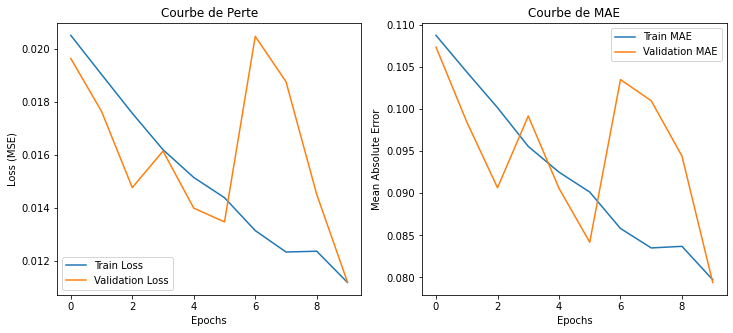

In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Courbe de Perte')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Courbe de MAE')
plt.legend()

plt.show()

In [10]:
model_age.save("model_age.keras")